# Diagnosing and Predicting Coronary Artery Disease

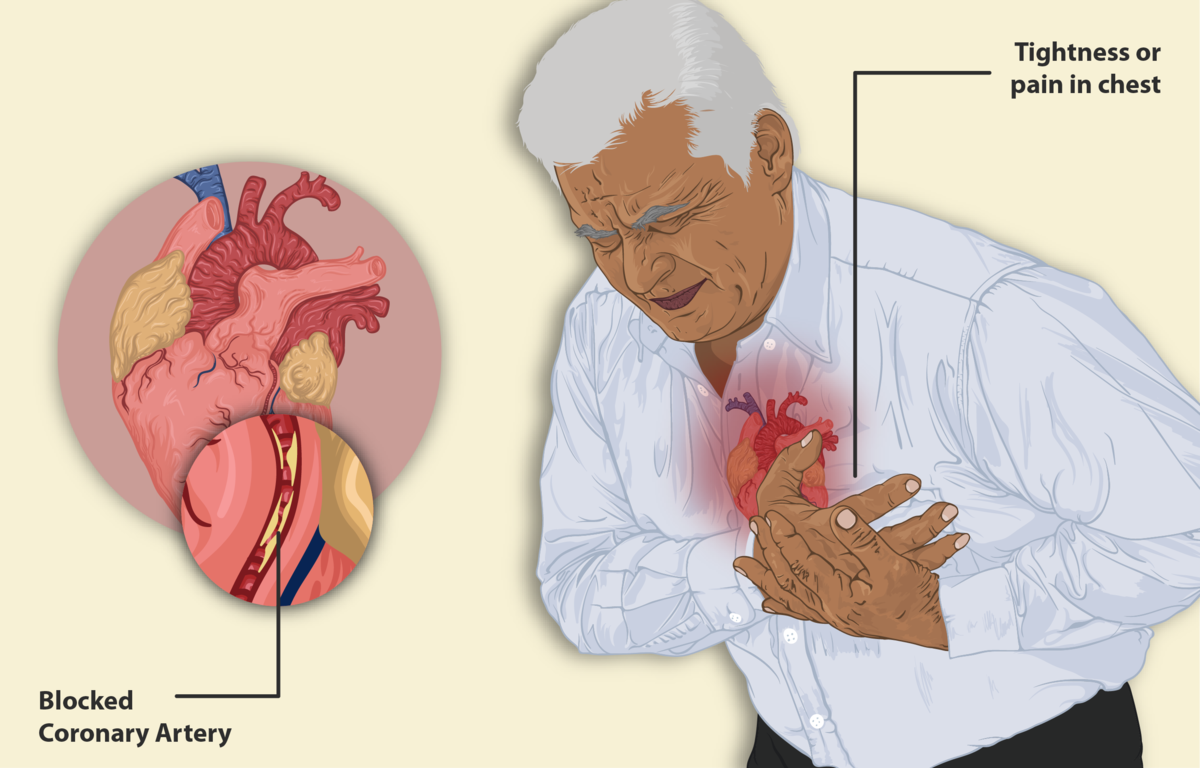

## Introduction: 

The coronary arteries are responsible for supplying the heart with sufficient blood, oxygen, and nutrients (Mayo Clinic, 2022). These arteries wrap around the heart to facilitate proper heart contraction and blood circulation (Sachdev, 2023).


Coronary Artery Disease (CAD) is a heart condition which occurs when the movement of blood through the coronary arteries gets restricted by the buildup of plaque on the inner walls of the coronary arteries. Plaque is a collection of different substances found in the blood - including cholesterol, fat, and calcium (Shahjehan & Bhutta, 2023). This blood flow obstruction can lead to angina, heart attacks, more complex cardiovascular diseases, reduced life expectancy and sudden death (Sachdev, 2023).


This CAD data analysis proposal outlines an approach to leverage data analysis techniques to develop an efficient predictive model to classify individuals based on whether they have CAD (or at risk of developing CAD) or not. 

**What is the likelihood of a patient having CAD based on the number of major vessels, thalassemia health condition, maximum heart rate, and exercise-induced angina?**  

This is a grouped dataset that contains observations from Cleveland, Hungary, Switzerland, and California..
**

## Methods    

To develop a well-rounded and more accurate data interpretation/classifier, the four different regions (Cleveland, Hungary, Switzerland, and California) will be combined into one dataframe. 


There will be 8 major steps in this data analysis: 

1. Reading the dataset: read the four separate dataframes into R

2. Data merging and initial cleaning: merge the four dataframes and create column headers. 

3. Data wrangling to create tidydata: transform the merged dataset according to tinydata conditions and conventional formatting.

4. Predictor variables selection: to find the 4 most relevant predictors (positive and negative), create a correlation plot to identify relationships between num (a binary diagnosis of CAD).

5. Training set (75%) and testing set (25%) split: To wrangle and train the model then test it's performance independently. 

6. K-Nearest Neighbors classification: set up knn classifier using cross-validation to find the optimal K value (# of nearest neighbors), then set up a workflow to start the model training process.

7. Effectiveness of the model: using the testing set and graphs (predictions laid atop their true 'label'), evaluate the k-nn classifier performance. 

8. Analysis of the results


## Preliminary exploratory data analysis

### Loading libraries

In [2]:
#install.packages("ggcorrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [17]:
library(tidyverse)    # allows data manipulation and visualization 
library(tidymodels)    # allows modelling and statistical analysis 
library(repr)    # string and binary representations of objects 
library(ggplot2)    # creates complex graphics
library(purrr)    # tools for functional programming and iterating functions 
library(stringr)    # string manipulation functions 
library(RColorBrewer)    # provides color schemes for graphics among other uses  
options(repr.matrix.max.rows = 6)    # limits output of dataframes to 6 rows
library(ggcorrplot)    # imports the function to create the correlation plot

### Reading and Wrangling our dataset into Tidydata

In [18]:
# From the source (https://archive.ics.uci.edu/dataset/45/heart+disease), this is a grouped dataset which contains observations from Cleveland, Hungary,Switzerland, and California.

# read each of the 4 datasets 
# transform the merged dataset according to tinydata conditions  

data1 <- read.csv("data/heart_disease/processed.cleveland.data", header = FALSE) |> # setting header to false since the dataset does not specify any, I will manually add these later.  
    map_df(function(x) gsub("?", NA, x, fixed = TRUE)) #replacing "?" with "NA" values and turning “num” into a binomial classifier.
           
data2 <- read.csv("data/heart_disease/processed.hungarian.data", header = FALSE) |> 
    map_df(function(x) gsub("?",NA,x, fixed = TRUE))
           
data3 <- read.csv("data/heart_disease/processed.switzerland.data", header = FALSE) |> 
    map_df(function(x) gsub("?",NA,x, fixed = TRUE))
           
data4 <- read.csv("data/heart_disease/processed.va.data", header = FALSE) |> 
    map_df(function(x) gsub("?",NA,x, fixed = TRUE))


# There are a total of 14 columns in this dataset (Janosi et al., 1988): 
    # 1. age: age (years) 
    # 2. sex: sex (0 = female, 1 = male)
    # 3. cp: chest pain type (4 types)
    # 4. trestbps: resting blood pressure (mmHg)
    # 5. chol: serum cholestrol levels (mg/dl)
    # 6. fbs: fasting blood pressure (> or < 120mg/dl)
    # 7. restecg: resting electrocardiographic results
    # 8. thalach: maximum heart rate achieved
    # 9. exang: exercise-induced angina (0 = false, 1 = true)
    # 10. oldpeak: ST depression induced by exercise relative to rest
    # 11. slope: slope of peak exercise ST segment (1 = uplope, 2 = flat, 3 = downslope)
    # 12. ca: number of major vessels (0-3) colored by fluoroscopy)
    # 13. thal: thalassemia health condition level (3 = normal, 6 = fixed defect, 7 = reversable defect)
    # 14. num: diagnosis of the heart disease

# since there are no header titles included in the original dataset, I will 1) merge all of the 4 regional datasets, then 2) add column names in manually 

heart_data <- 
    bind_rows(data1, data2, data3, data4) |>
    setNames(c("age", "sex", "cp", "trestbps", "chol", "fbs",
               "restecg", "thalach", "exang", "oldpeak", "slope", "ca",
               "thal", "num")) |>
    mutate_all(as.numeric) |>
    mutate(num = ifelse(is.na(num), NA, (num > 0)) |> as.numeric())

heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,NA,NA,6,1
58,1,4,NA,385,1,2,NA,NA,NA,NA,NA,NA,0
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


### Correlation plot

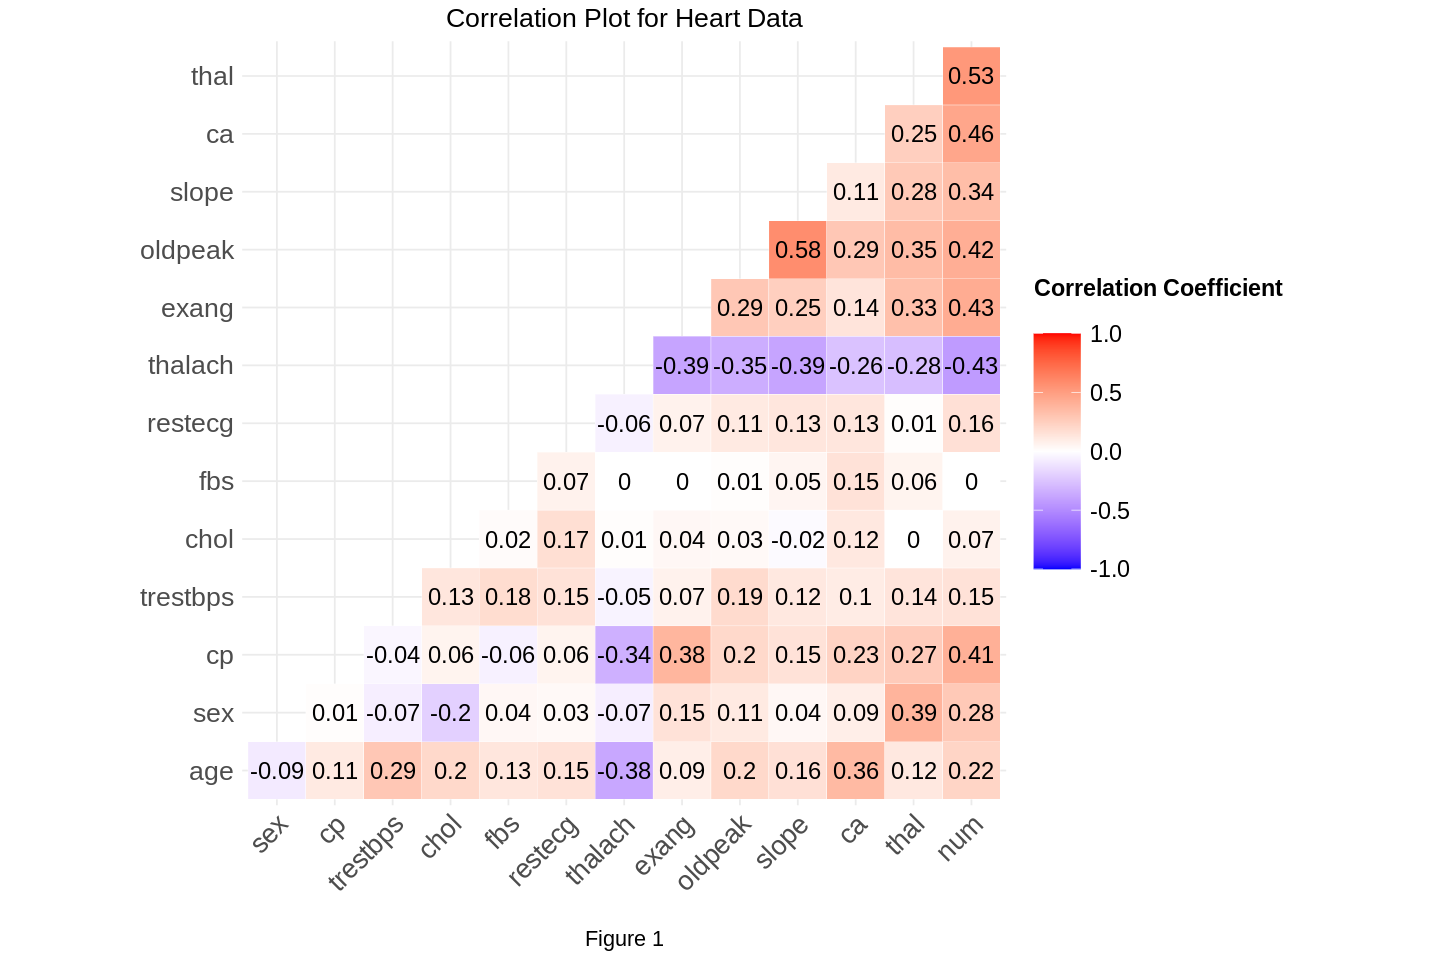

In [19]:
options(repr.plot.width = 12, repr.plot.height = 8)

# The R package corrplot is a tool which can help detect hidden patterns among variables 

corr_plot <- 
    heart_data |>
    cor(use="complete.obs") |>  # skips NA value rows
    ggcorrplot(outline.col = "white",
               type = "lower",
               lab = TRUE,
               lab_size = 5,
               tl.cex = 16,
               legend.title = "Correlation Coefficient\n") +
    labs(title = "Correlation Plot for Heart Data",
         caption = "\nFigure 1") +
    theme(legend.title = element_text(size = 14, face = "bold"),
          legend.text = element_text(size = 14),
          legend.key.size = unit(1, "cm"),
          plot.title = element_text(size = 16, hjust = 0.5),
          plot.caption = element_text(size = 13, hjust = 0.5))

corr_plot


### Splitting the data into a training and testing set 

In [20]:
# splitting the dataframe into a training_set (0.75) and a testing_set (0.25) 

set.seed(9999)

heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train
heart_test

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,1,4,158,170,0,1,138,1,0,NA,NA,NA,1
54,0,4,127,333,1,1,154,0,0,NA,NA,NA,1
55,1,4,122,223,1,1,100,0,0,NA,NA,6,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,1,4,160,254,1,1,108,1,3,2,NA,NA,1
46,1,4,134,310,0,0,126,0,0,NA,NA,3,1
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


### Understanding and summarizing the data

In [21]:
# How many obervations belong to patients with Coronary Artery Disease versus patients who do not have Coronary Artery Disease (the number of observations in each class)

data_per_class <- heart_train |> 
    group_by(num) |> 
    summarize(n = n()) 

data_per_class

num,n
<dbl>,<int>
0,308
1,381


In [22]:
# the max, mins, and means of the predictor variables used in this analysis

heart_summary_per_desired_column <- heart_train |> 
    group_by(num) |> 
    summarize(max_thalach = max(thalach, na.rm = TRUE), 
              min_thalach = min(thalach, na.rm = TRUE), 
              mean_thalach = mean(thalach, na.rm = TRUE), 
              max_exang = max(thalach, na.rm = TRUE),
              min_exang = min(thalach, na.rm = TRUE),
              mean_exang = mean(thalach, na.rm = TRUE),
              max_ca = max(ca, na.rm = TRUE), 
              min_ca = min(ca, na.rm = TRUE), 
              mean_ca = mean(ca, na.rm = TRUE), 
              max_thal = max(thal, na.rm = TRUE), 
              min_thal = min(thal, na.rm = TRUE), 
              mean_thal = mean(thal, na.rm = TRUE)) 

heart_summary_per_desired_column

# the resulting table shows the "sway" of unaffected patients versus CAD-affected patients. Although the max and min values are similar, the mean's show us the differences in where the majority of the datapoints lie


num,max_thalach,min_thalach,mean_thalach,max_exang,min_exang,mean_exang,max_ca,min_ca,mean_ca,max_thal,min_thal,mean_thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,194,69,149.0377,194,69,149.0377,3,0,0.2809917,7,3,4.066667
1,195,60,128.8230,195,60,128.8230,3,0,1.0769231,7,3,5.977901


In [23]:
# How many rows have missing data (excluded in the above 2 coding cells 

num_rows_without_na <- nrow(na.omit(heart_train)) 

num_rows_with_na <- nrow(heart_train) - num_rows_without_na

na_summary <- tibble(
    "Number of rows without NA values" = num_rows_without_na,
    "Number of rows with NA values" = num_rows_with_na) 

na_summary

Number of rows without NA values,Number of rows with NA values
<int>,<int>
220,469


### Useful visualizations that compare the distributions of chosen predictor variables 

#### (1) Maximum heart rate achieved : thalach histogram plot (numerical variable)

Warning message:
“Removed 41 rows containing non-finite outside the scale range (`stat_bin()`).”


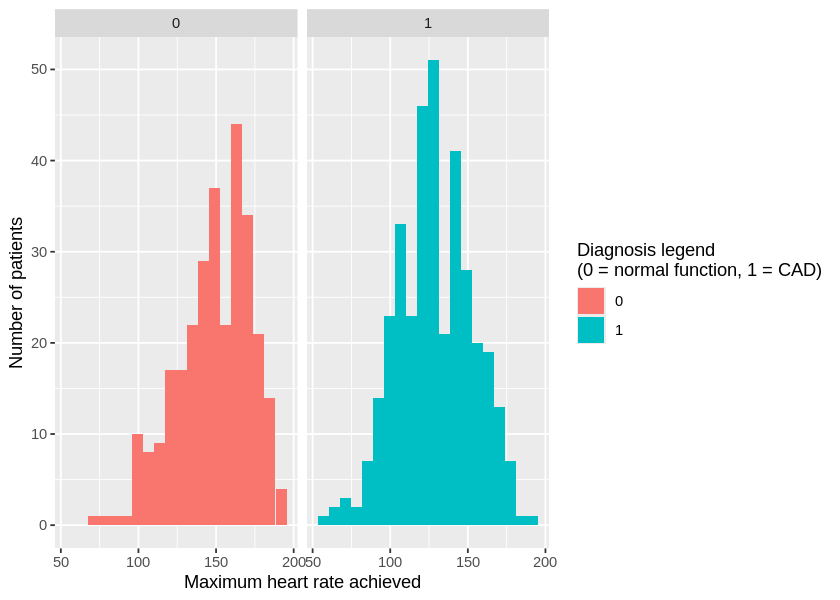

In [24]:
options(repr.plot.width = 7, repr.plot.height = 5)

thalach_histogram <- heart_train |> 
    ggplot(aes(x = thalach, fill = as_factor(num))) + 
    geom_histogram(bins = 20) + 
    labs(x = "Maximum heart rate achieved", y = "Number of patients", fill = "Diagnosis legend \n(0 = normal function, 1 = CAD)") + 
    facet_grid(cols = vars(num))

thalach_histogram

#### (2) Exercise induced angina : exang barplot (factor variable) 

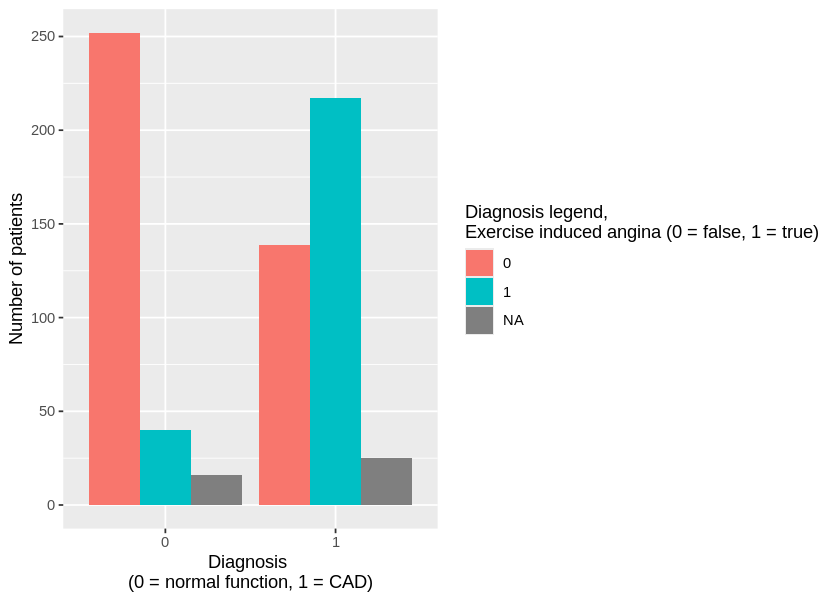

In [25]:
options(repr.plot.width = 7, repr.plot.height = 5)

exang_bar <- ggplot(heart_train, aes(x = as_factor(num), fill = as_factor(exang))) + 
    geom_bar(position = "dodge", stat = "count") + 
    labs(x = "Diagnosis \n(0 = normal function, 1 = CAD)", y = "Number of patients", fill = "Diagnosis legend, \nExercise induced angina (0 = false, 1 = true)")  

exang_bar 

#### (3) Number of major vessels colored by fluorosopy : ca barplot (factor variable) 

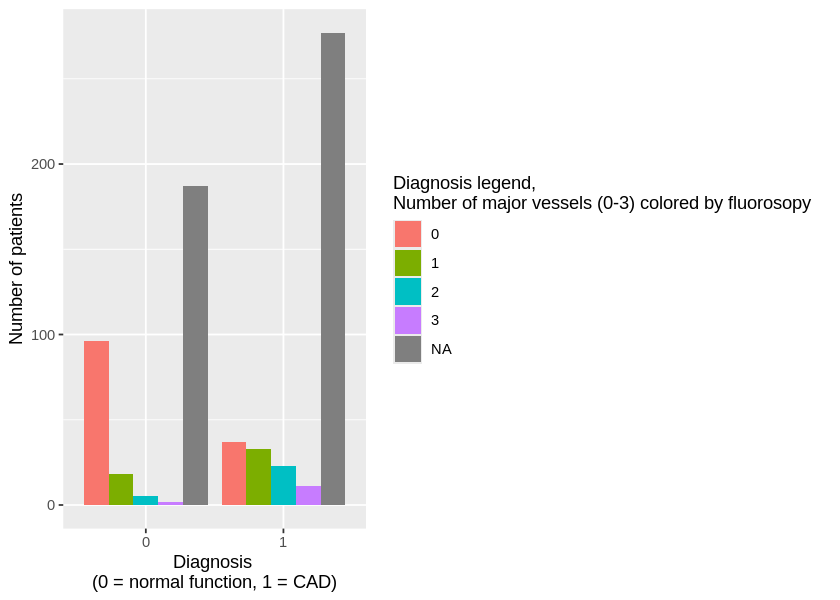

In [26]:
options(repr.plot.width = 7, repr.plot.height = 5)

ca_bar <- ggplot(heart_train, aes(x = as_factor(num), fill = as_factor(ca))) + 
    geom_bar(position = "dodge", stat = "count") + 
    labs(x = "Diagnosis \n(0 = normal function, 1 = CAD)", y = "Number of patients", fill = "Diagnosis legend, \nNumber of major vessels (0-3) colored by fluorosopy") 

ca_bar

#### (4) Thalassemia health condition level : thal barplot (factor variable) 

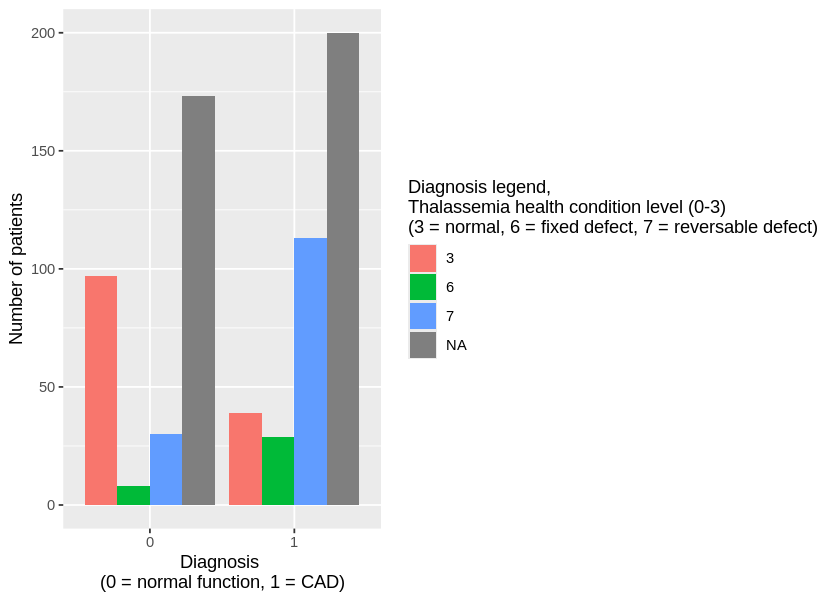

In [27]:
options(repr.plot.width = 7, repr.plot.height = 5)

thal_bar <- ggplot(heart_train, aes(x = as_factor(num), fill = as_factor(thal))) + 
    geom_bar(position = "dodge", stat = "count") + 
    labs(x = "Diagnosis \n(0 = normal function, 1 = CAD)", y = "Number of patients", fill = "Diagnosis legend, \nThalassemia health condition level (0-3) \n(3 = normal, 6 = fixed defect, 7 = reversable defect)") 

thal_bar


## Expected outcomes and significance of findings: 

Through proper data analysis, visualization, and knn-classifcation techniques, I expect to find that patients who are older, have high serum cholestrol levels (mg/dl), and have low maximum heart rates will likely be diagnosed with CAD or at least be highly likely to develop this medical condition.

By building a classifier that can accurately diagnose patients with Coronary Artery Disease (CAD), healthcare professionals would be able to identify and diagnose people with CAD, implement targetted interventions, and plan personalized treatment plans much more quickly and with confidence. This could result in a reduction of CAD-related health problems, and an increase in quality-of-lief for patients around the world. l

This data analysis could spark the investigation of more questions, including:
1) Which combinations of factors contribute the most to CAD? 
2) Can the region in which a patient lives in impact the severity of their disease? 


## Bibliography

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. Retrieved June 10, 2024, from https://archive.ics.uci.edu/dataset/45/heart+disease

Mayo Clinic. (2022). Coronary artery disease - Symptoms and causes. Mayo Clinic. Retrieved June 10, 2024, from https://www.mayoclinic.org/diseases-conditions/coronary-artery-disease/symptoms-causes/syc-20350613

Sachdev, P. (2023). Understanding Heart Failure – Diagnosis and Treatment. WebMD. Retrieved June 10, 2024, from https://www.webmd.com/heart-disease/heart-failure/understanding-heart-failure-treatment

Shahjehan, R. D., & Bhutta, B. S. (2023). Coronary Artery Disease. STATPearls. https://pubmed.ncbi.nlm.nih.gov/33231974/

